# Qualitative Classification Results


This notebook requies data and notebookdata
download via `bash download.sh data` and `bash download.sh notebookdata`

Train the models used in this notebook via

```bash
#!/usr/bin/env bash

seed=0
epochs=150
hyperparameterfolder="/home/marc/remote/crop-type-mapping/models/tune/12classes"
classmapping="/home/marc/remote/crop-type-mapping/data/BavarianCrops/classmapping12.csv"
for experiment in "isprs_tum_tempcnn" "isprs_tum_transformer" "isprs_tum_msresnet" "isprs_tum_rnn"; do
python train.py -x $experiment -e $epochs -b 256 -w 0 -i 0 --checkpoint_every_n_epochs 5 \
    --store /tmp/qualitative --test_every_n_epochs 1 \
    --no-visdom --seed $seed --hparamset $seed --classmapping $classmapping \
    --hyperparameterfolder $hyperparameterfolder
done
```

requires shapefile

```
!pgsql2shp -f /home/marc/remote/crop-type-mapping/models/notebookdata/qualitative/shp/holl_2018_mt_pilot.shp crops "select * from holl_2018_mt_pilot"
```

In [1]:
import sys
sys.path.append("../src")
sys.path.append("../src/models")
import numpy as np
from datasets.BavarianCrops_Dataset import BavarianCropsDataset
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
# install via !pip install contextily==1.0rc2
import contextily as ctx
from argparse import Namespace
from train import getModel

shp = "../data/notebookdata/qualitative/shp/holl_2018_mt_pilot.shp"
hparamfolder = "../models/tune/12classes"
runs = "../data/notebookdata/qualitative"


tum_dataset = BavarianCropsDataset(root="../data/BavarianCrops", 
                     region="holl", 
                     partition="test",
                     classmapping = "../data/BavarianCrops/classmapping12.csv", 
                     scheme="blocks",
                     samplet=70)

Initializing BavarianCropsDataset test partition in holl
read 12 classes
precached dataset files found at ../data/BavarianCrops/npy/classmapping12.csv/blocks/holl/test
loaded 9583 samples
Dataset ../data/BavarianCrops. region holl. partition test. X:9583x(144, 13), y:(9583,) with 12 classes


In [3]:
 
def evaluate(model):
    stats = list()
    model.cuda()
    model.eval()
    with torch.no_grad():
        for idx in tqdm(range(len(tum_dataset))):
            X,y,id = tum_dataset[idx]
            logsoftmax , *_ = model.forward(X[None,:,:].transpose(1,2).cuda())
            y_pred = logsoftmax.argmax()
            stats.append(
                dict(
                    y=int(y[0].numpy()),
                    y_pred = int(y_pred.detach().cpu().numpy()),
                    id=int(id)
                ))
    model.cpu()
    results = pd.DataFrame(stats).set_index("id")
    results.index.name = "ID"
    return results

In [4]:
from models.TransformerEncoder import TransformerEncoder
from models.multi_scale_resnet import MSResNet
from models.TempCNN import TempCNN
from models.rnn import RNN

def get_pth(run,exp):
    df = pd.read_csv(f"{run}/{exp}/log.csv")
    idx = df.loc[df["mode"] == "test"].loss.idxmin()
    epoch = df.loc[idx].epoch
    epoch = int(round(epoch/5)*5)
    pth = run+f"/{exp}/model_e{epoch}.pth"
    print(pth)
    return pth

def get_model(exp):
    input_dims = 13
    samplet = 70
    nclasses = 12
    dropout = 1.
    
    if exp=="isprs_tum_transformer":
        hparams = pd.read_csv(hparamfolder+"/transformer_tum.csv").iloc[0]
        
        hidden_dims = int(hparams["config/hidden_dims"])
        n_heads = int(hparams["config/n_heads"])
        n_layers = int(hparams["config/n_layers"])
        d_inner = hidden_dims*4

        model = TransformerEncoder(in_channels=input_dims, len_max_seq=samplet,
            d_word_vec=hidden_dims, d_model=hidden_dims, d_inner=d_inner,
            n_layers=n_layers, n_head=n_heads, d_k=hidden_dims//n_heads, d_v=hidden_dims//n_heads,
            dropout=dropout, nclasses=nclasses)

        model.load(get_pth(runs,exp))
    elif exp=="isprs_tum_tempcnn":
        hparams = pd.read_csv(hparamfolder+"/tempcnn_tum.csv").iloc[0]
        model = TempCNN(input_dim=input_dims, 
                        nclasses=nclasses, sequence_length=samplet, 
                        hidden_dims=int(hparams["config/hidden_dims"]), 
                        kernel_size=int(hparams["config/kernel_size"]))

        model.load(get_pth(runs,exp))
    elif exp=="isprs_tum_msresnet":
        hparams = pd.read_csv(hparamfolder+"/msresnet_tum.csv").iloc[0]
        model = MSResNet(input_channel=input_dims, 
                         layers=[1, 1, 1, 1], 
                         num_classes=nclasses, 
                         hidden_dims=int(hparams["config/hidden_dims"]))

        model.load(get_pth(runs,exp))
    elif exp=="isprs_tum_rnn":
        hparams = pd.read_csv(hparamfolder+"/rnn_tum.csv").iloc[0]
        model = RNN(input_dim=input_dims, 
                    nclasses=nclasses, 
                    hidden_dims=int(hparams["config/hidden_dims"]),
                    num_rnn_layers=int(hparams["config/num_layers"]), dropout=dropout, bidirectional=True)

        model.load(get_pth(runs,exp))
    return model


## Run pretrained models on data

In [ ]:
results = dict()
for exp in ["isprs_tum_msresnet","isprs_tum_tempcnn","isprs_tum_transformer","isprs_tum_rnn"]: #"isprs_tum_rnn",
    results[exp] = evaluate(get_model(exp))

../data/notebookdata/qualitative/isprs_tum_msresnet/model_e35.pth
loading model from ../data/notebookdata/qualitative/isprs_tum_msresnet/model_e35.pth



../data/notebookdata/qualitative/isprs_tum_tempcnn/model_e150.pth
loading model from ../data/notebookdata/qualitative/isprs_tum_tempcnn/model_e150.pth



../data/notebookdata/qualitative/isprs_tum_transformer/model_e75.pth
loading model from ../data/notebookdata/qualitative/isprs_tum_transformer/model_e75.pth


## Define some colors

In [8]:
# primary colors
tumblue=[0,101,189]
tumblack=[0, 0, 0]
tumwhite=[1, 1, 1]

# secundary colors
tumbluedark=[0,82,147]
tumbluelight=[152,198,234]
tumbluemedium=[100,160,200]

# tertiary colors
tumivory=[218,215,203]
tumgreen=[162,173,0]
tumorange=[227,114,34]
tumaubergine=[105,8,90]
tumnavyblue=[15,27,95]
tumturquoise=[0,119,138]
tumgreen=[0,124,48]
tumlimegreen=[103,154,29]
tumyellow=[255,220,0]
tumsand=[249,186,0]
tumredorange=[214,76,19]
tumred=[196,72,27]
tumdarkred=[156,13,22]

# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

def hex2rgb(hexcode):
    return tuple(map(ord,hexcode[1:].decode('hex')))


colors = {
    "fallow":tumblack,
    "grassland":tumgreen,
    "winter wheat":tumredorange,
    "corn":tumred,
    "summer wheat":tumorange,
    "winter spelt":tumbluedark,
    "winter rye":tumivory,
    "winter barley":tumlimegreen,
    "summer barley":tumturquoise,
    "summer oat":tumbluelight,
    "winter triticale":tumdarkred,
    "rapeseed":tumsand
}
from matplotlib.colors import ListedColormap
tumcmap = ListedColormap(np.array(list(colors.values())) / 255)

def save_plot(fig,fname):
    import os
    from matplotlib.backends.backend_pdf import PdfPages
    print(f"writing {fname}")
    os.makedirs(os.path.dirname(fname),exist_ok=True)
    with PdfPages(fname) as pdf:
        pdf.savefig(fig,bbox_inches='tight')

## Define Region of Interest and plot field parcels

{'init': 'epsg:31468'}
writing /tmp/qualitative_fig/qualitative.pdf


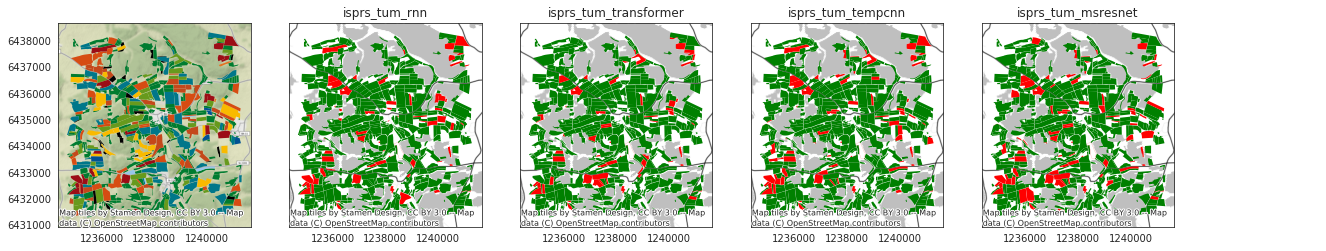

In [9]:

sx = 10000
sy = 8000
#x = 4470000
#y = 5535000
x = 4430000
y = 5528000

gdf = gpd.read_file(shp, bbox=[x, y, x + sx, y + sy])
print(gdf.crs)
gdf = gdf.set_index("ID").to_crs(epsg=3857)

correctcolor="g"
falsecolor="r"



def plot_results(ax,exp, title=True):
    selected_gdf = gdf.join(results[exp],how="inner")
    selected_gdf["correct"] = selected_gdf["y"] == selected_gdf["y_pred"]
    selected_gdf.loc[selected_gdf.correct].plot(ax=ax, edgecolor='none',legend=False, color=correctcolor)
    selected_gdf.loc[~selected_gdf.correct].plot(ax=ax, edgecolor='none',legend=False, color=falsecolor)
    ctx.add_basemap(ax=ax, zoom=13,url=ctx.providers.Stamen.Toner)
    if title:
        ax.set_title(exp)

fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

ax=axs[0]
gdf.join(results[exp],how="inner").plot(column="y",ax=ax, edgecolor='none',legend=False, cmap=tumcmap)
ctx.add_basemap(ax=ax, zoom=14)
plot_results(axs[1],"isprs_tum_rnn")
plot_results(axs[2],"isprs_tum_transformer")
plot_results(axs[3],"isprs_tum_tempcnn")
plot_results(axs[4],"isprs_tum_msresnet")

save_plot(fig,"/tmp/qualitative_fig/qualitative.pdf")

## Save figures separately for tikz

writing /tmp/qualitative_fig/labels.pdf
writing /tmp/qualitative_fig/isprs_tum_msresnet.pdf
writing /tmp/qualitative_fig/isprs_tum_tempcnn.pdf
writing /tmp/qualitative_fig/isprs_tum_transformer.pdf
writing /tmp/qualitative_fig/isprs_tum_rnn.pdf


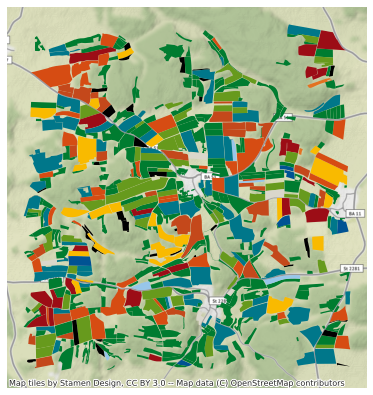

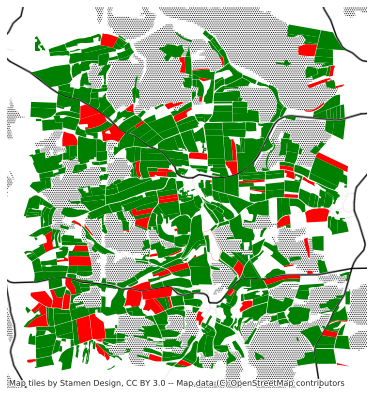

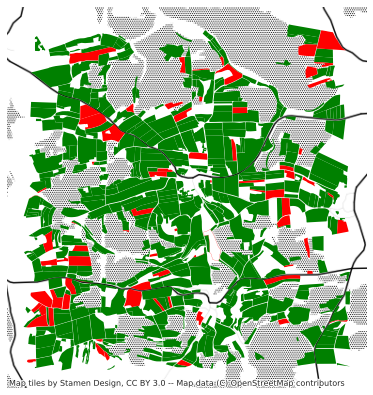

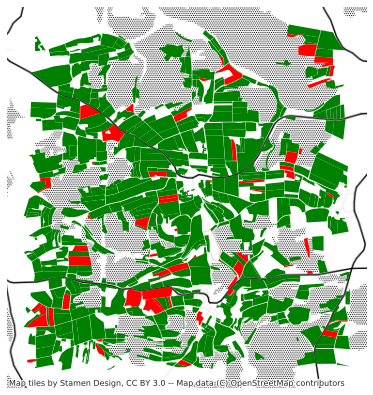

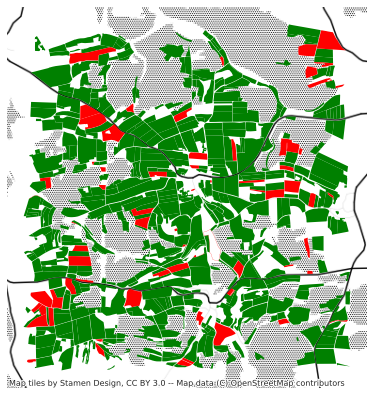

In [10]:

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
gdf.join(results[exp],how="inner").plot(column="y",ax=ax, edgecolor='none',legend=False, cmap=tumcmap)
ctx.add_basemap(ax=ax, zoom=14)
ax.axis("off")

save_plot(fig,"/tmp/qualitative_fig/labels.pdf")

for exp in ["isprs_tum_msresnet","isprs_tum_tempcnn","isprs_tum_transformer","isprs_tum_rnn"]:
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    plot_results(ax,exp, title=False)
    ax.axis("off")
    save_plot(fig,f"/tmp/qualitative_fig/{exp}.pdf")

## Additionals

Sanity checks to ensure that the selected area of interest is generally representative to the overall dataset in terms of evaluated accuracies

In [11]:
from sklearn.metrics import classification_report
for exp in ["isprs_tum_msresnet","isprs_tum_tempcnn","isprs_tum_rnn","isprs_tum_transformer"]:
    print(exp)
    print(classification_report(results[exp].y, results[exp].y_pred))


isprs_tum_msresnet
              precision    recall  f1-score   support

           0       0.72      0.21      0.32       487
           1       0.87      0.98      0.93      5591
           2       0.61      0.62      0.62       549
           3       0.95      0.91      0.93       691
           4       0.50      0.03      0.06        34
           5       0.21      0.25      0.23        20
           6       0.28      0.24      0.26        84
           7       0.77      0.69      0.73       486
           8       0.81      0.83      0.82       926
           9       0.44      0.12      0.18       163
          10       0.53      0.21      0.30       348
          11       0.82      0.99      0.90       204

    accuracy                           0.84      9583
   macro avg       0.63      0.51      0.52      9583
weighted avg       0.82      0.84      0.81      9583

isprs_tum_tempcnn
              precision    recall  f1-score   support

           0       0.79      0.27      0.

/home/marc/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
